In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
whas = pd.read_excel("C:\\Users\\soura\\Documents\\ECMM451\\resources\\other_data\\whas.xlsx")
whas.drop(['ID'] , axis = 1 , inplace = True)
# whas.shape
X = np.array(whas.iloc[: , :-2])
y = np.array(whas.iloc[: , -2:])

In [3]:
# get sorted index based on duration
idx = np.argsort(y[:,0])

# arrange events and covariates with same index
index = torch.Tensor(idx.astype('int64'))
durations = torch.Tensor(y[: , 0][idx].astype('int64'))
events = torch.Tensor(y[: , 1][idx].astype('int64'))
covariates = torch.Tensor(X[idx])

## Network

In [62]:
class MLP(nn.Module):
    def __init__(self , input_size , hidden_size , output_size , dropout_rate = 0.5):
        super(MLP , self).__init__()
        self.l1 = nn.Linear(input_size , hidden_size)
        self.l2 = nn.Linear(hidden_size , hidden_size)
        self.l3 = nn.Linear(hidden_size , output_size)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self , x):
        # stack layers
        out = self.l1(x)
        # out = out.view(1 , out.shape[0])
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.l2(out)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.l3(out)
        return out

## Loss

In [63]:
def nll_logistic_hazard(phi: Tensor, idx_durations: Tensor, events: Tensor, reduction: str = 'mean') -> Tensor:
    if phi.shape[1] <= idx_durations.max():
        raise ValueError(f"Network output `phi` is too small for `idx_durations`."+
                        f" Need at least `phi.shape[1] = {idx_durations.max().item()+1}`,"+
                        f" but got `phi.shape[1] = {phi.shape[1]}`")
    if events.dtype is torch.bool:
        events = events.float()
    events = events.view(-1, 1)
    idx_durations = idx_durations.view(-1, 1)
    y_bce = torch.zeros_like(phi)    
    y_bce = y_bce.type(torch.int64).scatter(1, idx_durations.type(torch.int64), events.type(torch.int64))
    bce = F.binary_cross_entropy_with_logits(phi, y_bce.type(torch.float32), reduction='none')
    loss = bce.cumsum(1).gather(1, idx_durations.type(torch.int64)).view(-1)
    # loss.requires_grad = True
    return loss.mean()

## Training

In [88]:
input_size = covariates.shape[1]
hidden_size = 100
output_size = index.shape[0]
learning_rate = 0.001
num_epochs = 200

model = MLP(input_size , hidden_size , output_size)

optimizer = torch.optim.Adam(model.parameters() , lr = learning_rate)

# Prime for training
model.train()
for epoch in range(num_epochs):
    # Create an empty list to store tensors
    tensor_list = []

    # # Generate and append tensors to the list dynamically
    # for i , covar in enumerate(covariates):
    #     output = model(covar)
    #     tensor_list.append(output)

    # Dynamically stack tensors
    # phi = torch.stack(tensor_list)

    phi = model(covariates)

    # get loss
    loss = nll_logistic_hazard(phi , index , events)

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%10==0: print(f'epoch {epoch} , loss {loss}')

# turn training off
model.eval()

epoch 0 , loss 176.85684204101562
epoch 10 , loss 139.12191772460938
epoch 20 , loss 104.82030487060547
epoch 30 , loss 75.98455047607422
epoch 40 , loss 55.97677993774414
epoch 50 , loss 42.936363220214844
epoch 60 , loss 32.55217361450195
epoch 70 , loss 24.659988403320312
epoch 80 , loss 19.95172882080078
epoch 90 , loss 16.70022964477539
epoch 100 , loss 14.248162269592285
epoch 110 , loss 12.005606651306152
epoch 120 , loss 10.750707626342773
epoch 130 , loss 10.340108871459961
epoch 140 , loss 8.564875602722168
epoch 150 , loss 7.8353424072265625
epoch 160 , loss 7.729866981506348
epoch 170 , loss 7.057493209838867
epoch 180 , loss 6.241583347320557
epoch 190 , loss 6.384840965270996


MLP(
  (l1): Linear(in_features=11, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=100, bias=True)
  (l3): Linear(in_features=100, out_features=481, bias=True)
  (relu): ReLU()
  (bn): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [83]:
#testing
hazards = torch.sigmoid(model(covariates[190:200]))
survival = torch.cumprod(1 - hazards , dim = 1)

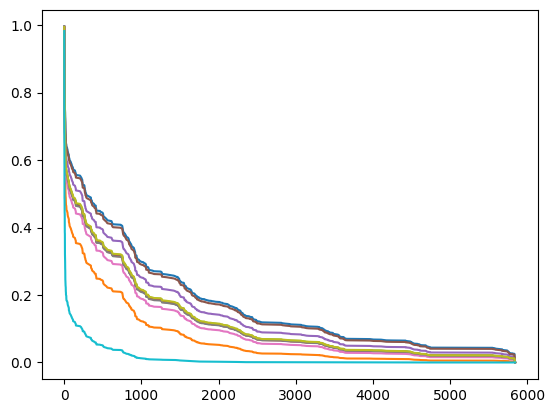

In [87]:
for surv in survival:
    plt.plot(durations , surv.detach().numpy())

TESTING

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 
import torch # For building the networks 
import torchtuples as tt # Some useful functions
from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(1234)
_ = torch.manual_seed(123)
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

#output nodes.

num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 2.9263,	val_loss: 2.7659
1:	[0s / 0s],		train_loss: 2.6603,	val_loss: 2.5461
2:	[0s / 0s],		train_loss: 2.3791,	val_loss: 2.2354
3:	[0s / 0s],		train_loss: 2.0756,	val_loss: 1.9005
4:	[0s / 0s],		train_loss: 1.7898,	val_loss: 1.5965
5:	[0s / 0s],		train_loss: 1.5691,	val_loss: 1.4399
6:	[0s / 0s],		train_loss: 1.4533,	val_loss: 1.3834
7:	[0s / 0s],		train_loss: 1.4080,	val_loss: 1.3732
8:	[0s / 0s],		train_loss: 1.3977,	val_loss: 1.3749
9:	[0s / 0s],		train_loss: 1.3683,	val_loss: 1.3710
10:	[0s / 0s],		train_loss: 1.3406,	val_loss: 1.3672
11:	[0s / 0s],		train_loss: 1.3476,	val_loss: 1.3632
12:	[0s / 0s],		train_loss: 1.3404,	val_loss: 1.3599
13:	[0s / 0s],		train_loss: 1.3284,	val_loss: 1.3536
14:	[0s / 0s],		train_loss: 1.3253,	val_loss: 1.3544
15:	[0s / 0s],		train_loss: 1.3170,	val_loss: 1.3566
16:	[0s / 0s],		train_loss: 1.3101,	val_loss: 1.3618
17:	[0s / 0s],		train_loss: 1.3191,	val_loss: 1.3643
18:	[0s / 0s],		train_loss: 1.2992,	val_loss: 1.3638
19:

In [4]:
in_features , out_features

(9, 10)